In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

from google.colab import files 
## Upload 'icu_data.csv' 
files.upload();

Saving icu_data.csv to icu_data.csv


In [ ]:
df = pd.read_csv("icu_data.csv")

## take out outcome variables
outcomevars = ["mort_icu","mort7","mort30","mort90","mort180","max_SOFA"]
dfout = df[ outcomevars ]

## remove unwanted columns from explanatory variables
to_remove = outcomevars + ["Unnamed: 0", "uo_d1"]
for var in df.columns:
    if var.find('_d') > -1 and var.find('_d1') == -1:
        to_remove.append(var)
df = df.drop( columns = to_remove )

## set NIV values in mech_vent_d1 to nan, and convert to int64
df.loc[ df["mech_vent_d1"] == "NIV", "mech_vent_d1"] = np.nan
df["mech_vent_d1"] = df["mech_vent_d1"].astype('float')

## now build predictors and outcome
X0 = df
y0 = dfout["mort7"]

## remove records without outcome
X1 = X0[ np.isfinite(y0) ]
y1 = y0[ np.isfinite(y0) ]

## impute missing values using median; don't use a pipeline, just apply SimpleImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X1, y1)

X = imp.transform(X1)
y = y1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(C=1, solver='saga', penalty='l2', max_iter=10000)

def score_model(model, X, y):
  scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
  print("%0.3f AUC with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

score_model(model, X, y)

model.fit(X, y)
model.coef_

0.766 AUC with a standard deviation of 0.034


array([[ 0.04580974, -0.02629265, -0.01276896, -0.00588778, -0.0010842 ,
        -0.00444406, -0.01684184,  0.05307983,  0.00076026,  0.09761775,
        -0.16520371, -0.00418982,  0.01200348, -0.03262842,  0.00381313,
        -0.00283562,  0.00938941, -0.01891483,  0.00574286, -0.00021556,
         0.00622484,  0.00168731,  0.0190309 , -0.00123877, -0.02131226,
         0.11636044,  0.02164101, -0.01925282, -0.08493227,  0.07781835,
         0.04428237]])

In [ ]:
model = LogisticRegression(C=1, solver='saga', penalty='l1', max_iter=10000)

score_model(model, X, y)

model.fit(X, y)
model.coef_

0.765 AUC with a standard deviation of 0.034


array([[ 4.54954229e-02, -1.90498655e-02, -1.27303007e-02,
        -5.88734453e-03,  0.00000000e+00, -1.57294225e-06,
        -1.03989578e-02,  4.40454548e-02,  0.00000000e+00,
         8.60714407e-02, -1.63879012e-01, -3.81420374e-03,
         1.19243401e-02, -2.55285863e-02,  0.00000000e+00,
        -2.82134576e-03,  8.97805807e-03, -1.85948235e-02,
         1.91986238e-04, -2.72747801e-04,  6.38921299e-03,
         1.69971309e-03,  1.21356571e-02, -1.17133180e-03,
        -1.44608095e-02,  1.05174206e-01,  1.52886719e-02,
        -1.42675475e-02, -7.57573752e-02,  6.97137074e-02,
         4.20906311e-02]])

In [ ]:
list(model.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

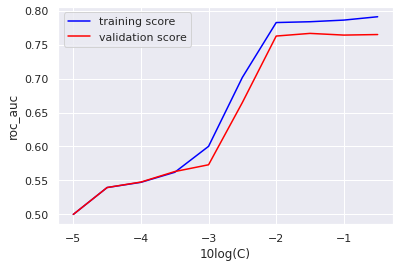

In [ ]:
from sklearn.model_selection import validation_curve
from math import log

## for l1
vals = np.power(10.0, np.arange(-5,0,0.5))
#vals = np.power(10.0, np.arange(-3.0,-1.7,0.1))

## for l2
#vals = np.power(10.0, np.arange(-5,0,0.1))
#vals = np.power(10.0, np.arange(-4,-3.5,0.05))

#scoring='average_precision'  ## give strange results
#scoring='accuracy'           ## this one also works well
scoring='roc_auc'

param = "C"

train_scores, test_scores = validation_curve(model, X, y, 
                                             param_name = param, param_range = vals, cv=5, scoring=scoring)

plt.plot(np.log(vals)/log(10.0), np.mean (train_scores, 1), color='blue', label='training score')
plt.plot(np.log(vals)/log(10.0), np.mean(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('10log(C)')
plt.ylabel(scoring);

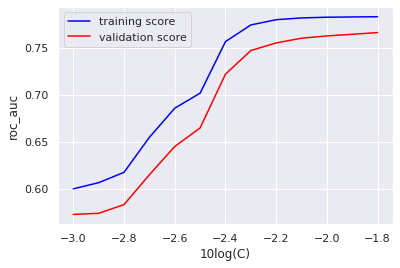

In [ ]:
vals = np.power(10.0, np.arange(-3.0,-1.7,0.1))
train_scores, test_scores = validation_curve(model, X, y, 
                                             param_name = param, param_range = vals, cv=5, scoring=scoring)

plt.plot(np.log(vals)/log(10.0), np.mean (train_scores, 1), color='blue', label='training score')
plt.plot(np.log(vals)/log(10.0), np.mean(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('10log(C)')
plt.ylabel(scoring);

In [ ]:
model.set_params(C = 10**-2.0)
score_model(model, X, y)
model.fit(X, y)

0.763 AUC with a standard deviation of 0.041


LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='saga')

In [ ]:
model.coef_

array([[ 0.03281123,  0.        , -0.01198127, -0.0011225 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.11294176,  0.        ,  0.01103057,  0.        ,  0.        ,
        -0.00293088,  0.        , -0.0081336 ,  0.        , -0.0008849 ,
         0.00613429,  0.00159499,  0.        , -0.00156746,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [ ]:
model.coef_ != 0

array([[ True, False,  True,  True, False, False, False, False, False,
        False,  True, False,  True, False, False,  True, False,  True,
        False,  True,  True,  True, False,  True, False, False, False,
        False, False, False, False]])

In [ ]:
list(df.columns[ (model.coef_ != 0)[0] ])

['age',
 'height',
 'weight',
 'gcs_d1',
 'fio2_d1',
 'sap_d1',
 'MAP_d1',
 'platelets_d1',
 'bili_d1',
 'creat_d1',
 'resp_d1_amount']

## Extra - does adding interactions improve the model?

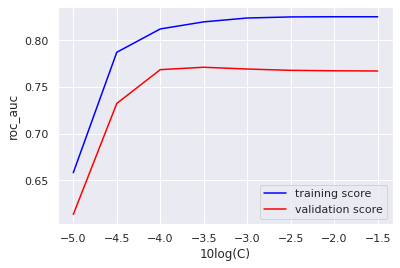

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

imp = SimpleImputer(missing_values=np.nan, strategy='median')

model = LogisticRegression(C=pow(10.0,-2.3), solver='saga', penalty = 'l1', max_iter=10000)

vars = ['age',
 'height',
 'gcs_d1',
 'fio2_d1',
 'sap_d1',
 'MAP_d1',
 'platelets_d1',
 'bili_d1',
 'creat_d1',
 'resp_d1_amount']

ct = ColumnTransformer([("cols", "passthrough", vars)], remainder="drop")

## We're making a pipeline, rather than using the pre-imputed Numpy array X, as X does not have named
## columns.  We could work without the names, it's just more convenient this way.
## We now need to use X1,y1 (data frames, before imputation) rather than X,y (numpy arrays, after imputation)
## 
## Warning: select columns BEFORE doing imputation.  Otherwise you get strange errors - is this a bug?

pipe = Pipeline([('columns', ct),
                 ('imputation', imp), 
                 ('interact', PolynomialFeatures(degree=2, interaction_only = True)),
                 ('model', model)])

## for l1
vals = np.power(10.0, np.arange(-5,-1,0.5))

scoring='roc_auc'

train_scores, test_scores = validation_curve(pipe, X1, y1, 
                                             param_name = 'model__C', param_range = vals, cv=5, scoring=scoring)

plt.plot(np.log(vals)/log(10.0), np.mean (train_scores, 1), color='blue', label='training score')
plt.plot(np.log(vals)/log(10.0), np.mean(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('10log(C)')
plt.ylabel('roc_auc');

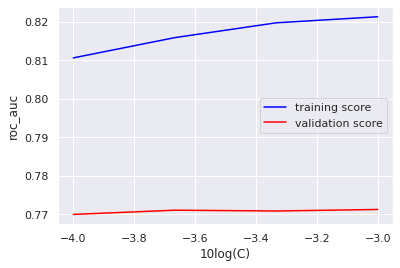

In [ ]:
vals = np.power(10.0, np.arange(-4,-3,0.333))

train_scores, test_scores = validation_curve(pipe, X1, y1, 
                                             param_name = 'model__C', param_range = vals, cv=10, scoring=scoring)

plt.plot(np.log(vals)/log(10.0), np.mean (train_scores, 1), color='blue', label='training score')
plt.plot(np.log(vals)/log(10.0), np.mean(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('10log(C)')
plt.ylabel('roc_auc');

In [ ]:
## which columns have nonzero coefficients?
pipe.set_params(model__C = 10**-3.8)
score_model(pipe, X1, y1)

pipe.fit(X1,y1)
nonzeros = (pipe[-1].coef_ != 0)[0]
print("There are ",np.sum(nonzeros)," nonzero coefficients.")

0.772 AUC with a standard deviation of 0.033
There are  24  nonzero coefficients.


Adding interactions to the model improves the AUC from 0.763 to 0.772.  The model now includes 24 nonzero coefficients.